# Machine Learning Engineer Nanodegree

## Capstone Project

### Using Computer Vision for Facial Expression Classification

This project seeks to investigate the use of computer vision techniques to build a classifier that can classify different faces, based on facial expressions.

The effectiveness of different convolutional neural network architectures will be investigated. 






In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint  

from keras import backend as K
from keras import applications
from keras import optimizers

%matplotlib inline

Using TensorFlow backend.


The dataset can be obtained from [here](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge). For the purpose of this notebook, and determining the best classification model, only the first 15,000 entries will be used. Later, the entire dataset will be used for training, testing and validation on the optimal model, to gain an idea for the true performance of the model.

In [2]:
data = pd.read_csv("fer2013cp.csv")

labels = data['emotion']

features = data.drop(['emotion','Usage'], axis=1, inplace=False)


temp_list = []

for i in features['pixels']:
    temp_list.append(i.split())
    
features.drop('pixels',axis=1,inplace=True)

features['pixels'] = pd.Series(temp_list)

In [3]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size = 0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=0)

In [4]:
def df_to_tensor(X_in, im_dim, reshape=True, triple_channels=False):
    
    # convert from the dataframe which contains 
    
    list_of_2d_arrays = []
    
    
    
    for image in X_in['pixels']:
        pixel_array = []
        
        for pixel in image:
            if not triple_channels:
                pixel_array.append(int(pixel))
            else:
                pixel_array.append([int(pixel),int(pixel),int(pixel)])
        
        pixel_array = [pixel_array[x:x+im_dim] for x in range(0,len(pixel_array),im_dim)]
        
        
        
        list_of_2d_arrays.append(pixel_array)
        
    np_arr =  np.array(list_of_2d_arrays)
    
    #print(np_arr.shape)
    if reshape:
        return np_arr.reshape(np_arr.shape[0], 48, 48, 1)
    else:
        return np_arr

In [17]:
samples = df_to_tensor(X_train,48)

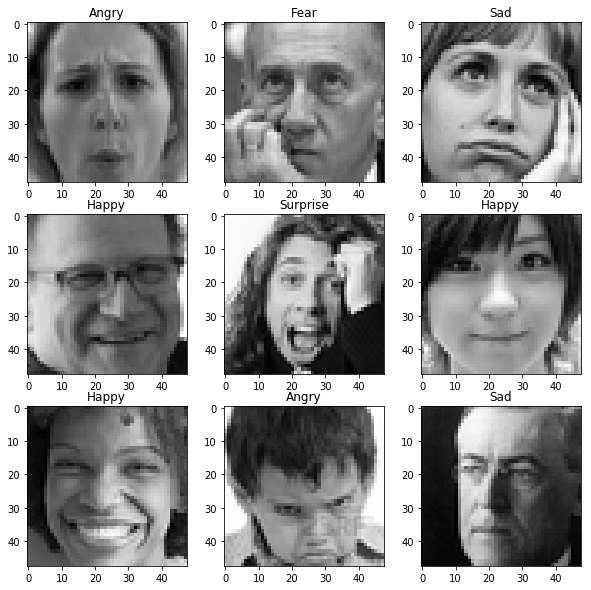

In [18]:
seed_number = 21

two_d_array = samples[seed_number].reshape(48,48)

fig = plt.figure(figsize=(10, 10))

num_rows = 3

num_columns = 3

hardcoded_labels = ["Angry", "Fear", "Sad", "Happy", "Surprise",
                   "Happy", "Happy", "Angry", "Sad"]

for i in range(num_rows*num_columns):
    ax = fig.add_subplot(num_rows,num_columns,i + 1)
    ax.imshow(samples[seed_number + i].reshape(48,48), cmap='gray')
    ax.title.set_text(hardcoded_labels[i])



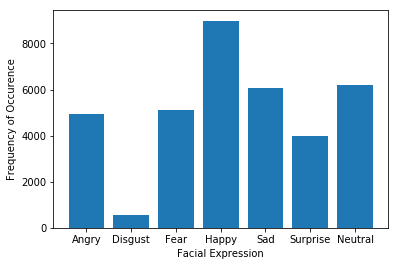

In [19]:
# seeing the distribution of each emotion in the dataset

frequency_list = np.zeros(7)

for label in labels:
    frequency_list[int(label)] += 1
    
emotion_indices = range(1,8)

x_axis_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise',
         'Neutral']


bar = plt.bar(emotion_indices, frequency_list, align='center')

plt.xticks(emotion_indices, x_axis_labels )

plt.xlabel("Facial Expression")

plt.ylabel("Frequency of Occurence")



plt.show()

In [44]:
import cv2

"""

color_img = cv2.cvtColor(samples[3].reshape(48,48), cv2.CV_GRAY2RGB)

ax.imshow(color_img)


"""

AttributeError: module 'cv2.cv2' has no attribute 'CV_GRAY2RGB'

In [20]:
train_tensors = df_to_tensor(X_train,48).astype('float32')/255
valid_tensors = df_to_tensor(X_val,48).astype('float32')/255
test_tensors = df_to_tensor(X_test,48).astype('float32')/255

train_targets = np.array(pd.get_dummies(y_train))
valid_targets = np.array(pd.get_dummies(y_val))
test_targets = np.array(pd.get_dummies(y_test))


In [21]:
img_width = 48
img_height = 48

In [22]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
                 input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 12, 12, 256)       295168    
__________

In [23]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 20

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 22967 samples, validate on 5742 samples
Epoch 1/20
22967/22967 [==============================] - 24s - loss: 1.7078 - acc: 0.3134 - val_loss: 1.5806 - val_acc: 0.4096
Epoch 2/20
22967/22967 [==============================] - 24s - loss: 1.4552 - acc: 0.4408 - val_loss: 1.3814 - val_acc: 0.4582
Epoch 3/20
22967/22967 [==============================] - 24s - loss: 1.3397 - acc: 0.4963 - val_loss: 1.3168 - val_acc: 0.4902
Epoch 4/20
22967/22967 [==============================] - 23s - loss: 1.2721 - acc: 0.5219 - val_loss: 1.2853 - val_acc: 0.5178
Epoch 5/20
22967/22967 [==============================] - 23s - loss: 1.2308 - acc: 0.5450 - val_loss: 1.2870 - val_acc: 0.5101
Epoch 6/20
22967/22967 [==============================] - 23s - loss: 1.2008 - acc: 0.5554 - val_loss: 1.2325 - val_acc: 0.5305
Epoch 7/20
22967/22967 [==============================] - 23s - loss: 1.1872 - acc: 0.5652 - val_loss: 1.2694 - val_acc: 0.5246
Epoch 8/20
22967/22967 [==============================]

In [27]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [29]:
# get index of predicted facial expression for test set images
expression_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(expression_predictions)==np.argmax(test_targets, axis=1))/len(expression_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 56.3388%


Below, explore transfer learning

In [30]:
import cv2

X_train_transf, X_test_transf, X_val_transf = X_train, X_test, X_val

y_train_transf, y_test_transf, y_val_transf = y_train, y_test, y_val


sample = df_to_tensor(X_train_transf, 48, reshape=False)

#sample.shape

In [31]:
# creating transfer tensors

train_tensors_transf = df_to_tensor(X_train_transf,48,reshape=False, triple_channels=True).astype('float32')/255
valid_tensors_transf = df_to_tensor(X_val_transf,48, reshape=False, triple_channels=True).astype('float32')/255
test_tensors_transf = df_to_tensor(X_test_transf,48, reshape=False, triple_channels=True).astype('float32')/255

train_targets_transf = np.array(pd.get_dummies(y_train_transf))
valid_targets_transf = np.array(pd.get_dummies(y_val_transf))
test_targets_transf = np.array(pd.get_dummies(y_test_transf))


In [32]:
# Note: the code below is an adaptation of a code snippet by Prakash Jay,
# obtained from: https://towardsdatascience.com/transfer-learning-using-keras-d804b2e04ef8

img_width, img_height = 48, 48
"""
train_data_dir = "data/train"
validation_data_dir = "data/val"
nb_train_samples = 4125
nb_validation_samples = 466 
"""
batch_size = 16
epochs = 50

model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))


model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [ ]:
"""
for layer in model.layers:
    layer.trainable = False
"""

#allow training in initial layers for now, to see what the result is

In [33]:
# duplicate of prakash jay code
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
#two additional dense layers below with same dropout
#unsure whether it will help, go back to two if 
#needed
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [34]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.transfer_example_six.hdf5', 
                               verbose=1, save_best_only=True)

model_final.fit(train_tensors_transf, train_targets_transf, 
          validation_data=(valid_tensors_transf, valid_targets_transf),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 22967 samples, validate on 5742 samples
Epoch 1/20
22967/22967 [==============================] - 148s - loss: 1.8568 - acc: 0.2220 - val_loss: 1.8182 - val_acc: 0.2454
Epoch 2/20
22967/22967 [==============================] - 155s - loss: 1.7368 - acc: 0.2816 - val_loss: 1.6917 - val_acc: 0.3342
Epoch 3/20
22967/22967 [==============================] - 154s - loss: 1.6537 - acc: 0.3392 - val_loss: 1.6380 - val_acc: 0.3692
Epoch 4/20
22967/22967 [==============================] - 155s - loss: 1.5968 - acc: 0.3717 - val_loss: 1.5693 - val_acc: 0.4187
Epoch 5/20
22967/22967 [==============================] - 155s - loss: 1.5487 - acc: 0.4093 - val_loss: 1.5194 - val_acc: 0.4249
Epoch 6/20
22967/22967 [==============================] - 155s - loss: 1.5064 - acc: 0.4267 - val_loss: 1.4693 - val_acc: 0.4276
Epoch 7/20
22967/22967 [==============================] - 148s - loss: 1.4641 - acc: 0.4421 - val_loss: 1.4800 - val_acc: 0.4429
Epoch 8/20
22967/22967 [========================

In [35]:
model_final.load_weights('saved_models/weights.best.transfer_example_six.hdf5')

In [36]:
# get index of predicted facial expression for test set images
expression_predictions_transf = [np.argmax(model_final.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors_transf]

# report test accuracy
test_accuracy = 100*np.sum(np.array(expression_predictions_transf)==np.argmax(test_targets_transf, axis=1))/len(expression_predictions_transf)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 54.5556%


BELOW: INCEPTION RESNET V2

In [16]:
img_width, img_height = 48, 48
"""
train_data_dir = "data/train"
validation_data_dir = "data/val"
nb_train_samples = 4125
nb_validation_samples = 466 
"""
batch_size = 16
epochs = 50

#this time, using inception resnetv2

model_xception = applications.xception.Xception(include_top=True, weights='imagenet', input_tensor=None, input_shape=(48,48,3), pooling=None)


model_irv2.summary()

ValueError: Input size must be at least 71x71; got `input_shape=(48, 48, 3)`

In [7]:
# duplicate of prakash jay code
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()
